<a href="https://colab.research.google.com/github/Baah134/Baah134/blob/main/Audio%20Classification/AudioClassificationTransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==2.10.0 tensorflow-io==0.27.0 matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.0/25.0 MB 68.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 73.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 46.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found ex

In [2]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio


In [3]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [4]:
from google.colab import drive
drive.mount('/content/drive')

BASE_PATH = '/content/drive/MyDrive/DeepLearning/Audio_Classification/data'

Mounted at /content/drive


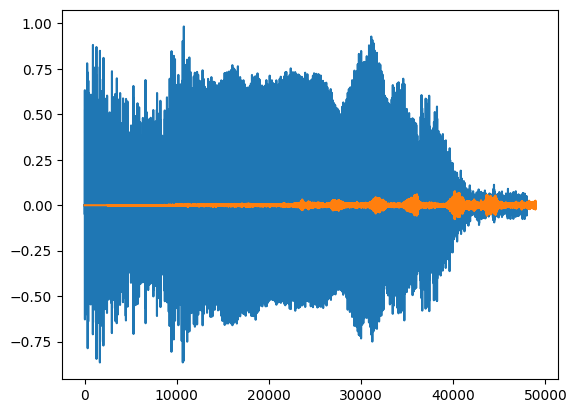

In [5]:
CAPUCHIN_FILE = os.path.join(BASE_PATH, 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join(BASE_PATH, 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

plt.plot(wave)
plt.plot(nwave)
plt.show()

In [6]:
from google.colab import drive
drive.mount('/content/drive')


POS = '/content/drive/MyDrive/DeepLearning/Audio_Classification/data/Parsed_Capuchinbird_Clips'
NEG = '/content/drive/MyDrive/DeepLearning/Audio_Classification/data/Parsed_Not_Capuchinbird_Clips'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

In [8]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [9]:
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    #

    spectrogram = tf.expand_dims(spectrogram, axis=2)

    #


    return spectrogram, label

In [10]:
def preprocess_rgb(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    # Ensure spectrogram has a defined shape before applying tf.repeat
    spectrogram = tf.ensure_shape(spectrogram, [1491, 257])
    # Reshape to add a channels dimension before repeating
    spectrogram = tf.expand_dims(spectrogram, axis=-1)
    spectrogram = tf.repeat(spectrogram, 3, axis=-1) # Convert to RGB
    return spectrogram, label

data_rgb = positives.concatenate(negatives)
data_rgb = data_rgb.map(preprocess_rgb)
data_rgb = data_rgb.cache()
data_rgb = data_rgb.shuffle(buffer_size=1000)
data_rgb = data_rgb.batch(16)
data_rgb = data_rgb.prefetch(8)

In [11]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

spectrogram, label = preprocess(filepath, label)

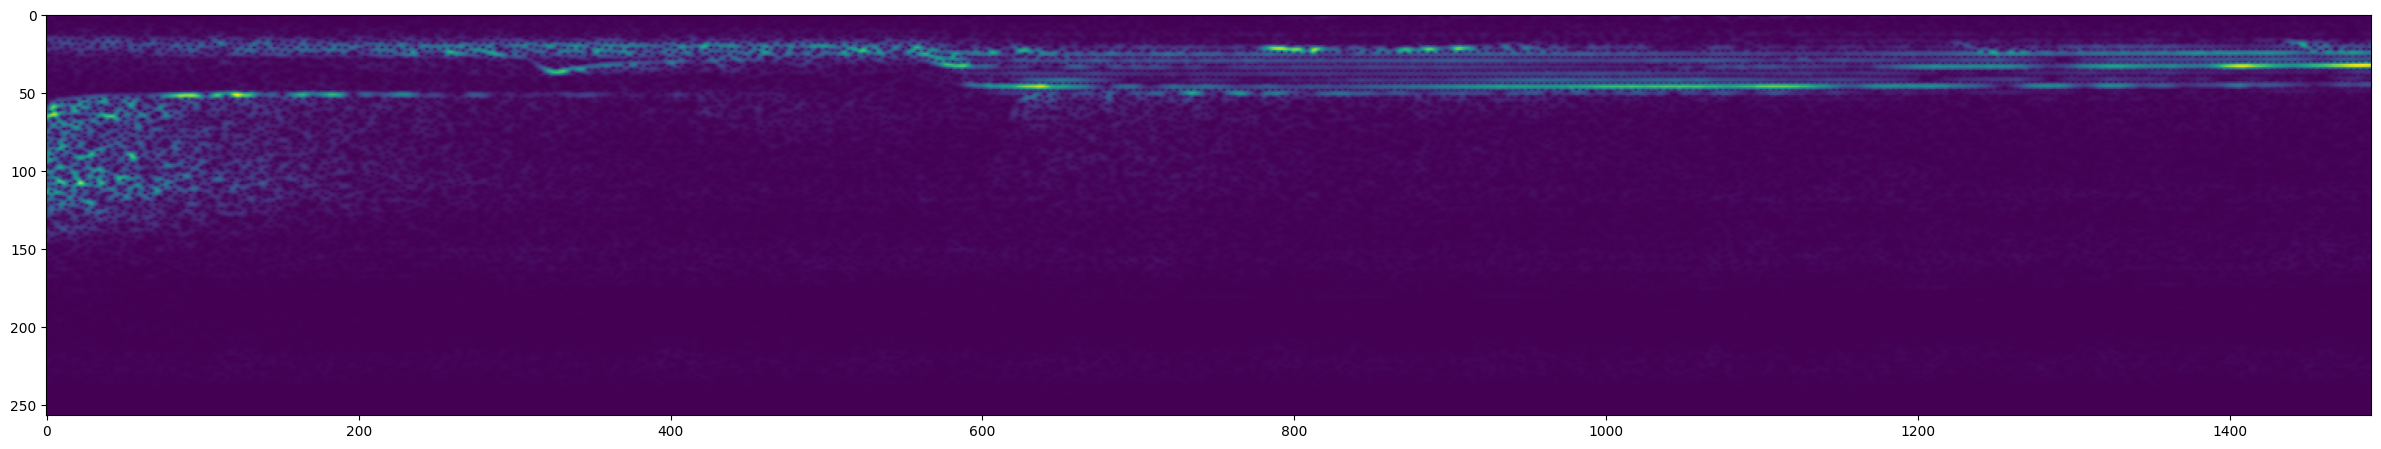

In [12]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [13]:
train = data_rgb.take(36)
test = data_rgb.skip(36).take(15)

In [14]:
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [15]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape =(1491, 257,3 ))
base_model.trainable = False ## Not trainable weights

58889256/58889256 [==============================] - 0s 0us/step


In [16]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(1, activation='sigmoid')

model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

In [17]:
hist = model.fit(train, epochs=2, validation_data=test)

Epoch 1/2
36/36 [==============================] - 1207s 33s/step - loss: 0.5145 - accuracy: 0.8542 - val_loss: 0.0944 - val_accuracy: 0.9786
Epoch 2/2
36/36 [==============================] - 1197s 34s/step - loss: 0.0484 - accuracy: 0.9861 - val_loss: 0.0181 - val_accuracy: 0.9915


In [18]:
model.save_weights('/content/drive/MyDrive/DeepLearning/Audio_Classification/my_model_weights.h5')

In [20]:
X_test, y_test = test.as_numpy_iterator().next()
yhat = model.predict(X_test)

1/1 [==============================] - 24s 24s/step


In [21]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]
yhat

[0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]

In [22]:
def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav



In [23]:
def preprocess_rgb_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(sample, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    # Ensure spectrogram has a defined shape before applying tf.repeat
    spectrogram = tf.ensure_shape(spectrogram, [1491, 257])
    # Reshape to add a channels dimension before repeating
    spectrogram = tf.expand_dims(spectrogram, axis=-1)
    spectrogram = tf.repeat(spectrogram, 3, axis=-1) # Convert to RGB
    return spectrogram, label

In [ ]:
from itertools import groupby

results = {}
for file in os.listdir(os.path.join(BASE_PATH, 'Forest Recordings')):
    FILEPATH = os.path.join(BASE_PATH,'Forest Recordings', file)

    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_rgb_mp3)
    audio_slices = audio_slices.batch(64)

    yhat = model.predict(audio_slices)

    results[file] = yhat

1/1 [==============================] - 86s 86s/step


1/1 [==============================] - 86s 86s/step


In [1]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

NameError: name 'results' is not defined

In [ ]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

In [ ]:
import csv
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])